In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf
import mealpy
import time

2022-10-12 16:44:15.291994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("../data/creditcard.csv")
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
label = "Class"
#class_weight = {0: 0.1, 1: 0.9}
metrics = ["Accuracy", "Precision", "Recall"]

test_inds = np.random.rand(len(df)) < 0.2
train_df = df[~test_inds]
test_df = df[test_inds]

In [4]:
train = train_df.to_numpy()
features = train[:, 1:29]
labels = train[:, 30]
train.shape

(227933, 31)

In [5]:
# begin VPPSO, given feature matrix and label vector
# Step 1 & 2: Create y bins and load instances
bins = [np.squeeze(features[np.argwhere(labels == y),:]) 
        for y in np.unique(labels)]
[b.shape for b in bins]

[(227536, 28), (397, 28)]

In [6]:
# Step 5: Cluster particles into k clusters within each bin
from sklearn.cluster import KMeans

def cluster(bins, k=8):
    trobs = []
    labelz = []
    for i, b in enumerate(bins):
        km = KMeans(n_clusters=k)
        km.fit(b)
        # Step 6: Select equal number of particles from each cluster
        trobs += km.cluster_centers_.tolist()
        labelz += [i for center in km.cluster_centers_]
    return trobs, labelz

def train_rf(bins, k=8):
    train_obs, labelz = cluster(bins, k)
    vp_train_df = pd.DataFrame(train_obs, columns=train_df.columns[1:29])
    vp_train_df[label] = labelz
    # convert pandas df to tensor ds
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(vp_train_df, label=label)
    # create and fit default RF model
    model = tfdf.keras.RandomForestModel(verbose=0)
    model.compile(metrics=metrics)
    model.fit(x=train_ds)#, class_weight=class_weight)
    return model

In [7]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)

K = [8,12,16,20]

models = {k: train_rf(bins, k) for k in K}

/Users/chase/opt/miniconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
2022-10-12 16:44:21.431361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/chase/opt/miniconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
[INFO kernel.cc:1176] Loading model from path /var/folders/82/xcxtg5353f

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/Users/chase/opt/miniconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
[INFO kernel.cc:1176] Loading model from path /var/folders/82/xcxtg5353f918mx036g0f8q00000gn/T/tmp5kwucp_h/model/ with prefix 494f406d64074949
[INFO decision_forest.cc:639] Model loaded with 300 root(s), 1188 node(s), and 28 input feature(s).
[INFO kernel.cc:1022] Use fast generic engine
/Users/chase/opt/miniconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
[INFO kernel.cc:1176] Loading model from path /var/folders/82/xcxtg5353f918mx036g0f8q00000gn/T/tmpxcn_3zwi/model/ with prefix

57/57 [==============================] - 1s 23ms/step
k=8: AUROC 0.9018262867757817
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56779
           1       0.02      0.88      0.04        95

    accuracy                           0.92     56874
   macro avg       0.51      0.90      0.50     56874
weighted avg       1.00      0.92      0.96     56874

57/57 [==============================] - 1s 23ms/step
k=12: AUROC 0.8751762373227316
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     56779
           1       0.01      0.89      0.02        95

    accuracy                           0.86     56874
   macro avg       0.51      0.88      0.47     56874
weighted avg       1.00      0.86      0.92     56874

57/57 [==============================] - 1s 24ms/step
k=16: AUROC 0.8905780584185592
              precision    recall  f1-score   support

           0       1.00      0.89    

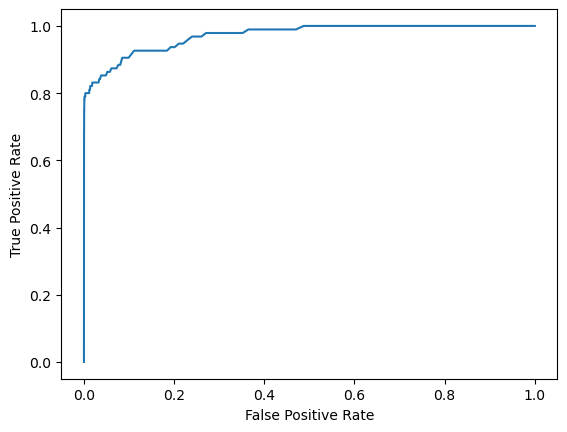

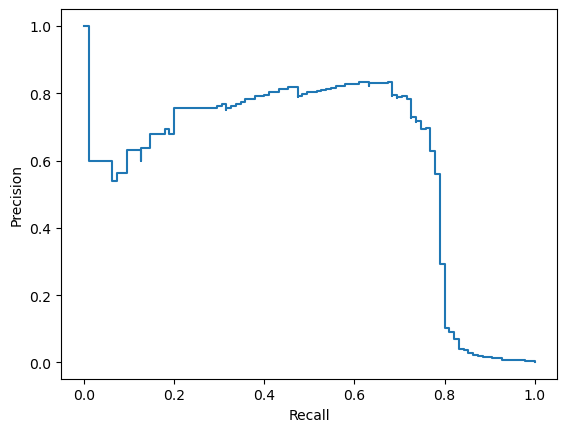

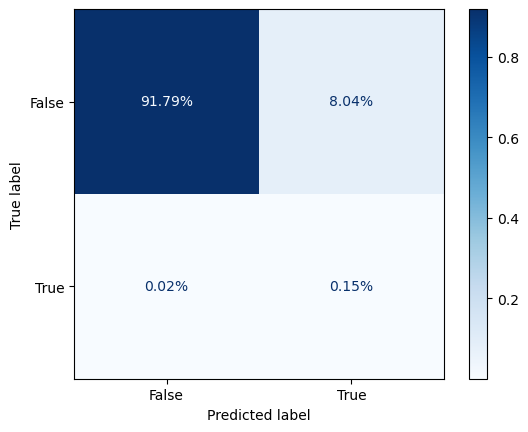

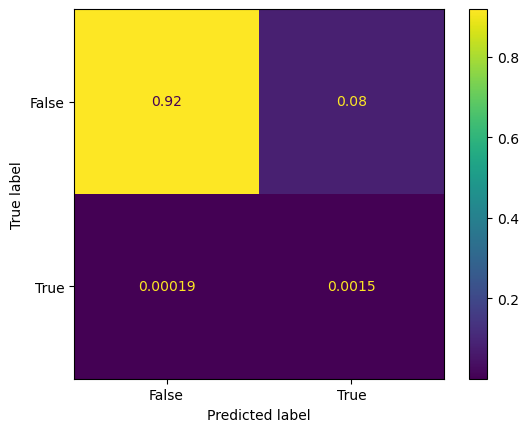

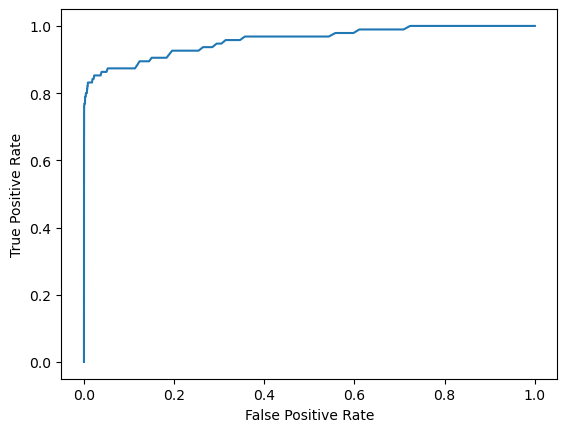

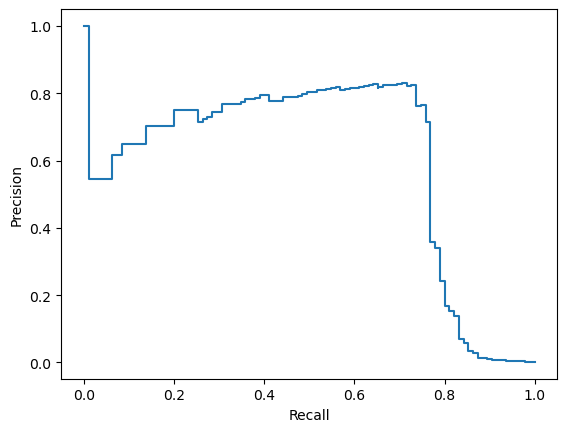

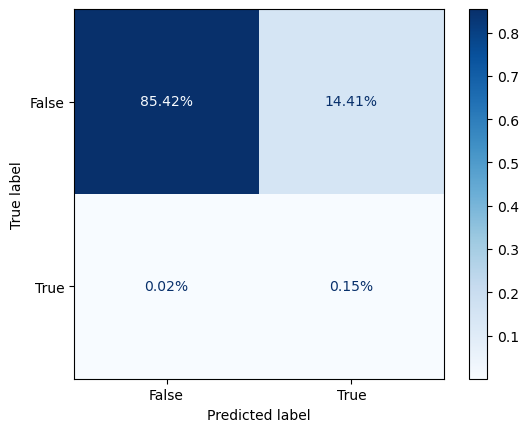

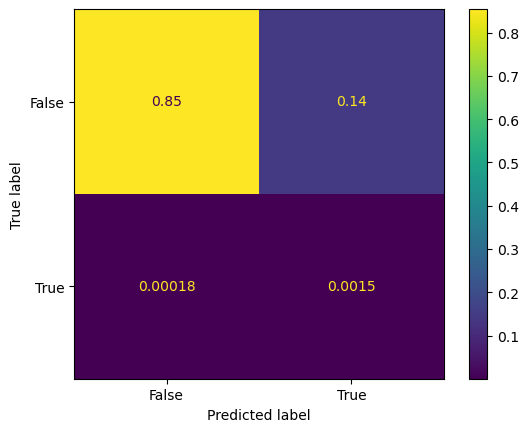

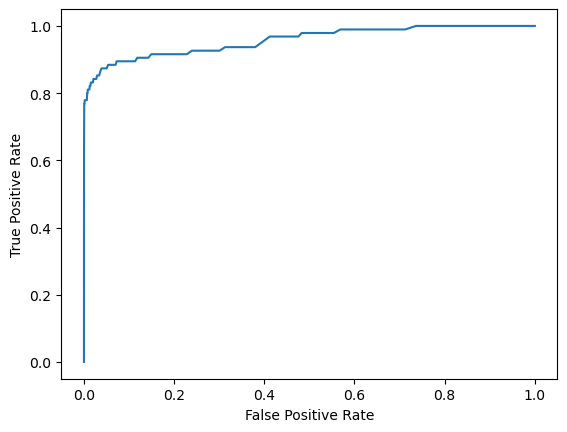

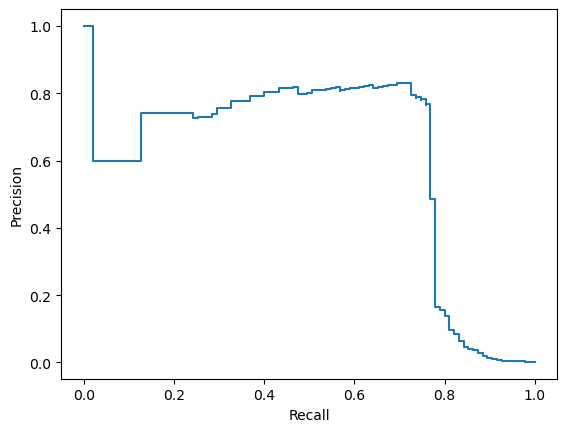

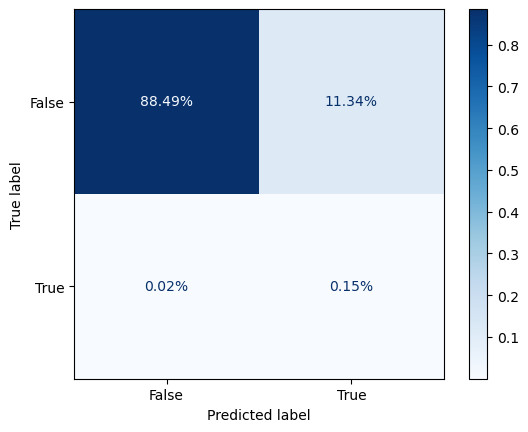

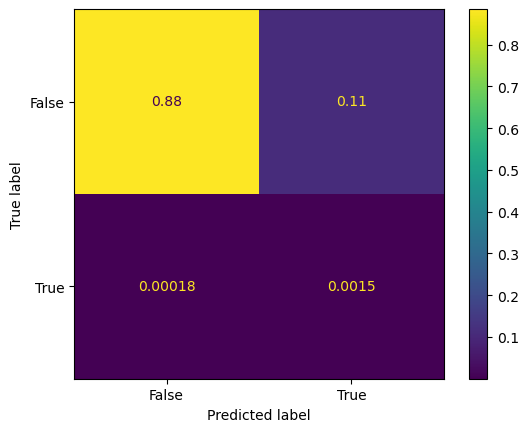

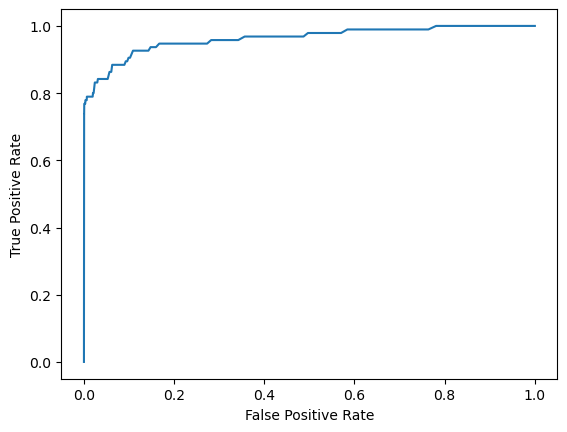

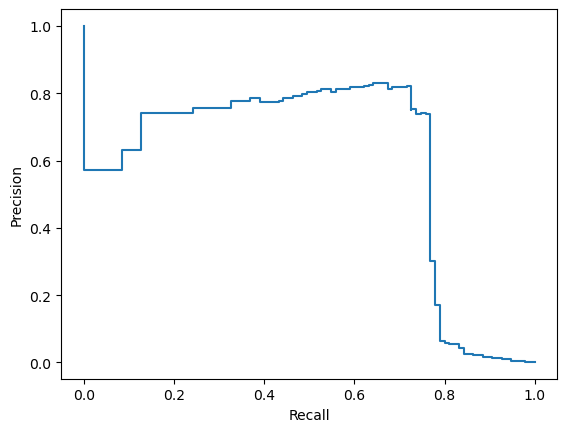

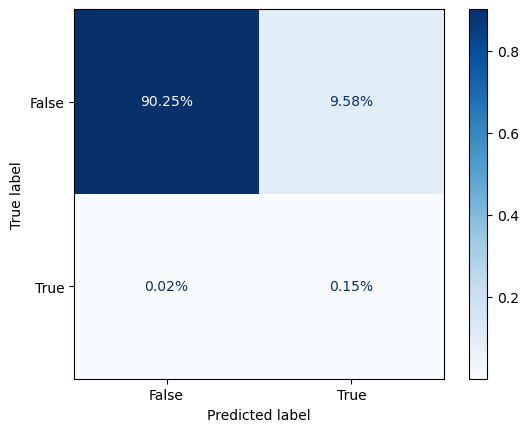

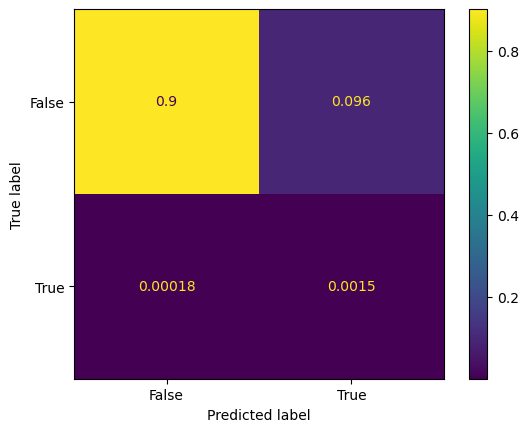

In [10]:
import matplotlib.pyplot as plt
from sklearn import metrics

y_test = test_df[label]

for k, model in models.items():
    # evaluate on test set
    yhat = model.predict(test_ds)
    fpr, tpr, threshold = metrics.roc_curve(y_test, yhat)
    y_pred = yhat > threshold[tpr > 0.90][0]
    print(f'k={k}: AUROC', metrics.roc_auc_score(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred))
    #calculate precision and recall
    precision, recall, thresh = metrics.precision_recall_curve(y_test, yhat)
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, yhat)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    disp = metrics.PrecisionRecallDisplay(precision, recall).plot()
    disp = metrics.ConfusionMatrixDisplay.from_predictions(
        y_test.astype('bool'), y_pred.astype('bool'), cmap='Blues',
        normalize='all', values_format='.2%')

In [ ]:
#calculate precision and recall
precision, recall, thresh = metrics.precision_recall_curve(y_test, yhat)

fpr, tpr, threshold = metrics.roc_curve(y_test, yhat)

disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
disp = metrics.PrecisionRecallDisplay(precision, recall).plot()
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test.astype('bool'), y_pred.astype('bool'), cmap='Blues',
    normalize='all', values_format='.2%').plot()

In [ ]:
pd.DataFrame(evals)

In [ ]:
def f(model):
    eva = model.evaluate(test_ds, return_dict=True)
    return eva['accuracy']

# Import backend modules
import pyswarms.backend as P
from pyswarms.backend.topology import Star

my_topology = Star() # The Topology Class
my_options = {'c1': 0.6, 'c2': 0.3, 'w': 0.4} # arbitrarily set
my_swarm = P.create_swarm(n_particles=50, 
                          dimensions=2, 
                          options=my_options) # The Swarm Class

iterations = 10
for i in range(iterations):
    # Part 1: Update personal best
    my_swarm.current_cost = f(my_swarm.position) # Compute current cost
    my_swarm.pbest_cost = f(my_swarm.pbest_pos)  # Compute personal best pos
    my_swarm.pbest_pos, my_swarm.pbest_cost = P.compute_pbest(my_swarm) # Update and store

    # Part 2: Update global best
    # Note that gbest computation is dependent on your topology
    if np.min(my_swarm.pbest_cost) < my_swarm.best_cost:
        my_swarm.best_pos, my_swarm.best_cost = my_topology.compute_gbest(my_swarm)

    # Let's print our output
    if i%20==0:
        print('Iteration: {} | my_swarm.best_cost: {:.4f}'.format(i+1, my_swarm.best_cost))

    # Part 3: Update position and velocity matrices
    # Note that position and velocity updates are dependent on your topology
    my_swarm.velocity = my_topology.compute_velocity(my_swarm)
    my_swarm.position = my_topology.compute_position(my_swarm)

print('The best cost found by our swarm is: {:.4f}'.format(my_swarm.best_cost))
print('The best position found by our swarm is: {}'.format(my_swarm.best_pos))
